## 1. Installing Data

In [1]:
!pip -q install yfinance

# 2. Importing Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Downloading Stock Data

In [3]:
ticker = "AAPL"  # you can change later
df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
df = df.dropna()
df.head()

/tmp/ipython-input-3429843809.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468254,72.528574,71.223252,71.476592,135480400
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800
2020-01-06,72.335533,72.374139,70.634517,70.885450,118387200
2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200


# Plotting the Price

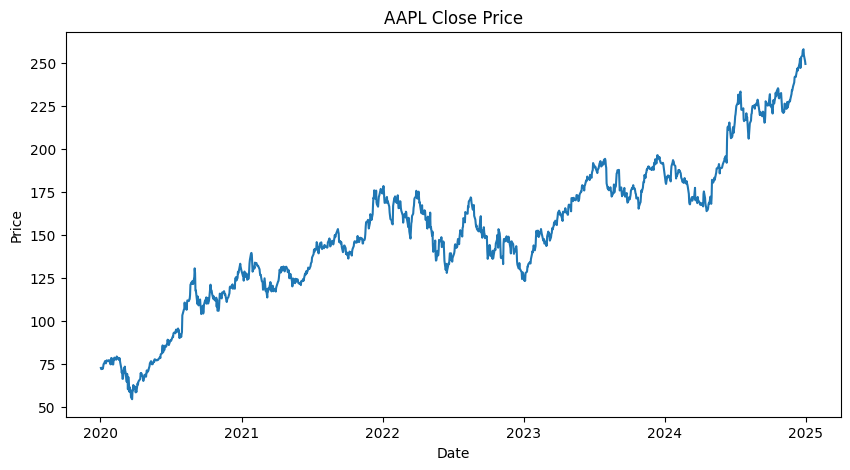

In [4]:
plt.figure(figsize=(10,5))
plt.plot(df["Close"])
plt.title(f"{ticker} Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Adding Fast and Slow Moving Averages

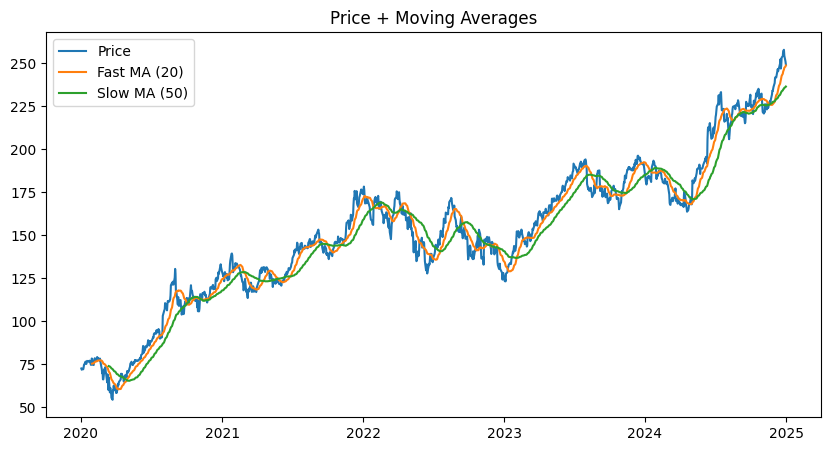

In [5]:
FAST = 20
SLOW = 50

df["fast_ma"] = df["Close"].rolling(FAST).mean()
df["slow_ma"] = df["Close"].rolling(SLOW).mean()

plt.figure(figsize=(10,5))
plt.plot(df["Close"], label="Price")
plt.plot(df["fast_ma"], label=f"Fast MA ({FAST})")
plt.plot(df["slow_ma"], label=f"Slow MA ({SLOW})")
plt.title("Price + Moving Averages")
plt.legend()
plt.show()

# Adding RSI

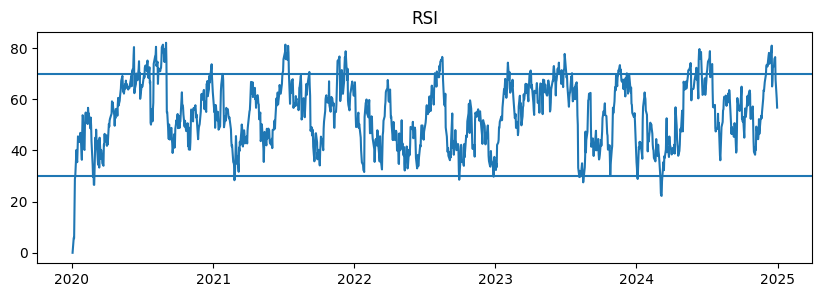

In [6]:
def rsi(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

RSI_PERIOD = 14
df["rsi"] = rsi(df["Close"], RSI_PERIOD)

plt.figure(figsize=(10,3))
plt.plot(df["rsi"])
plt.axhline(70)
plt.axhline(30)
plt.title("RSI")
plt.show()

# Deciding the Signal

In [7]:
df["signal"] = ((df["fast_ma"] > df["slow_ma"]) & (df["rsi"] < 70)).astype(int)
df[["fast_ma", "slow_ma", "rsi", "signal"]].tail()

Price,fast_ma,slow_ma,rsi,signal
Ticker,,,,
Date,,,,
2024-12-24,245.184587,234.761245,75.750254,0
2024-12-26,246.377192,235.267494,76.452855,0
2024-12-27,247.405540,235.746621,67.626244,1
2024-12-30,248.145692,236.150895,60.225577,1
2024-12-31,248.684755,236.463049,56.715927,1


# Not using Today's Prices

In [8]:
df["position"] = df["signal"].shift(1).fillna(0)

# Computing Returns

In [9]:
df["ret"] = df["Close"].pct_change().fillna(0)
df["strategy_ret"] = df["position"] * df["ret"]

# Converting Returns to the Equity Curve

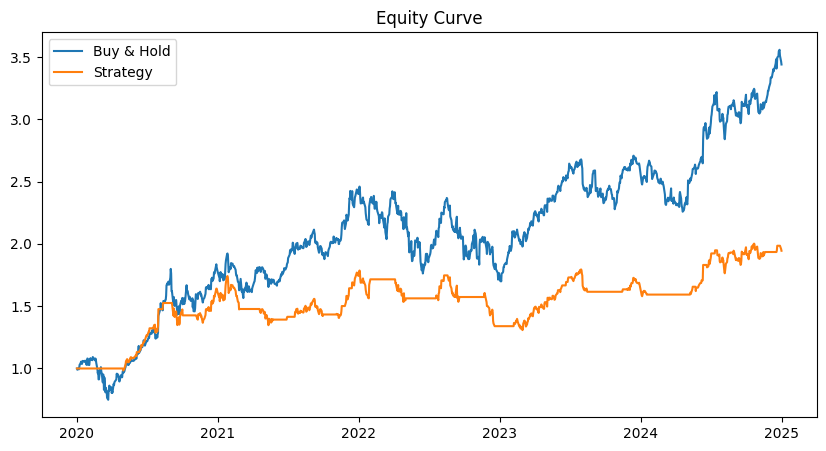

In [10]:
df["equity_strategy"] = (1 + df["strategy_ret"]).cumprod()
df["equity_buyhold"] = (1 + df["ret"]).cumprod()

plt.figure(figsize=(10,5))
plt.plot(df["equity_buyhold"], label="Buy & Hold")
plt.plot(df["equity_strategy"], label="Strategy")
plt.title("Equity Curve")
plt.legend()
plt.show()

# Adding metrics

In [11]:
def max_drawdown(equity):
    peak = equity.cummax()
    dd = equity/peak - 1
    return dd.min()

def sharpe(daily_returns):
    if daily_returns.std() == 0:
        return np.nan
    return np.sqrt(252) * daily_returns.mean() / daily_returns.std()

years = len(df) / 252
cagr = df["equity_strategy"].iloc[-1]**(1/years) - 1

print("Final equity:", df["equity_strategy"].iloc[-1])
print("CAGR:", cagr)
print("Sharpe:", sharpe(df["strategy_ret"]))
print("Max Drawdown:", max_drawdown(df["equity_strategy"]))
print("Trades:", int(df["position"].diff().abs().fillna(0).sum()))

Final equity: 1.9449871165790316
CAGR: 0.14254999093477894
Sharpe: 0.8104527602821844
Max Drawdown: -0.26786967539227713
Trades: 95
